##  Check first on Checkability and Checkworthiness

To Check on Checkability, the first workflow of the EUFactcheck programme will be followed (https://eufactcheck.eu/about-us/eufactcheck-flowchart/). The student will also be involved to provide more information and to check the output.

In [1]:
import getpass
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama
import tqdm as notebook_tqdm

load_dotenv(dotenv_path=".env", override=True)

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"]="pr-left-technician-100"

llm = ChatOllama(model="qwen3:1.7b-q4_K_M", temperature=0, base_url="http://localhost:11434")

import sys
import os
sys.path.append(os.path.abspath("./src"))

c:\temp\checkmate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The next part determines which data should be stored in AgentState (memory of the program), and how certain output should be structured using pydantic.

In [ ]:
#%%writefile ./src/state_scope.py
"""
State Definitions and Pydantic Schemas for testing if a claim is checkable.

This defines the state objects and structured schemas used for Checking on checkability and check worthiness
of claims.
"""

from typing_extensions import TypedDict, Annotated, Sequence, Literal, List, Optional
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from operator import add as add_messages
from langgraph.graph.message import MessagesState

# Input state for the full agent
class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

# Create an object to hold the state of the agent
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    claim: str 
    checkable: Optional[bool]
    subject: Optional[str]
    quantitative: Optional[bool]
    precision: Optional[str]
    based_on: Optional[str]
    confirmed: bool
    question: Optional[str]
    alerts: List[str]
    
#output models for structured output
class SubjectResult(BaseModel):
    subject: str = Field("", description="Main subject of the claim, if identifiable")
    checkable: Literal["POTENTIALLY CHECKABLE", "UNCHECKABLE"]
    explanation: str
    question: str = Field("", description="Question to user for clarification if needed")
    alerts: List[str] = Field([], description="Any alerts or warnings about the claim")


class MoreInfoResult(BaseModel):
    quantitative: bool
    precision: str = Field("", description="How precise is it?")
    based_on: str = Field("", description="how was the data collected or derived?")
    explanation: str
    question: str = Field("", description="Question to user for clarification if needed")
    alerts: List[str] = Field([], description="Any alerts or warnings about the claim")

class ConfirmationResult(BaseModel):
    claim: str
    explanation: str
    question: str = Field("", description="Question to user for verification")

The functions of all the nodes

In [ ]:
#%%writefile ./src/state_checkable_nodes.py

"""
Nodes for checking if a claim is potentially checkable.

"""

from langchain_core.messages import HumanMessage,AIMessage,get_buffer_string
from prompts import opinion_prediction_check, more_info_check,summary_confirmation_check
from state_scope import AgentState, SubjectResult, MoreInfoResult, AgentInputState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command


def check_fact_subject(state: AgentState) -> Command[Literal["gather_information", "__end__"]]:
    """
    Check if a claim is potentially checkable.
    """
    # Use structured output to get a boolean and explanation as output
    structured_llm = llm.with_structured_output(SubjectResult)

    # System prompt for checkability
    checkability_prompt  =  opinion_prediction_check.format(
        claim=state.get("claim", ""),
        messages=get_buffer_string(state.get("messages", [])),
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=checkability_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())

    # checkable is a boolean in State
    is_checkable = result.checkable == "POTENTIALLY CHECKABLE"


    # print output
    print("\n=== 1. CHECKABLE? ===")
    print(f"{result.checkable}")
    print(f"{result.explanation}")
    print(f"subject: {result.subject}")
    print(f"question: {result.question}")
    print(f"alerts: {result.alerts}")


    if not is_checkable:
        # Pause for user confirmation
        return Command(
                goto=END, 
                update={
                    "question": result.question or "Could you add some evidence, if you do think it is potentially checkable?",
                    "checkable": is_checkable,
                    "messages": list(state.get("messages", [])) + [ai_msg],
                }
        )   
    else:
        # If potentially checkable but subject unclear, ask for clarification
        if not result.subject.strip():
            return Command(
                goto=END, 
                update={
                    "question": result.question or "Who's the main subject?",
                    "checkable": is_checkable,
                    "messages": list(state.get("messages", [])) + [ai_msg],
                    "alerts": list(state.get("alerts", [])) + [result.alerts]
                }
            )
        else:
            return Command(
                goto="gather_information",
                update={
                    "checkable": is_checkable,
                    "messages": list(state.get("messages", [])) + [ai_msg],
                    "subject": result.subject,
                },
            )
        
def gather_information(state: AgentState) -> Command[Literal["get_confirmation", "__end__"]]:
    """
    Gather more information about a potentially checkable claim.
    """
    # Use structured output to get a boolean and explanation as output
    structured_llm = llm.with_structured_output(MoreInfoResult)

    # System prompt for checkability
    more_info_prompt  =  more_info_check.format(
        claim=state.get("claim", ""),
        subject=state.get("subject", ""),
        messages=get_buffer_string(state.get("messages", [])),
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=more_info_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())


    # print output
    print("\n=== 2. Evidence retrieved? ===")
    print(f"quantitative: {result.quantitative}")
    print(f"precision: {result.precision}")
    print(f"based on: {result.based_on}")
    print(f"{result.explanation}")
    print(f"question: {result.question}")
    print(f"alerts: {result.alerts}")

    if not result.quantitative:
        # Pause for user confirmation
        return Command(
                goto=END, 
                update={
                    "question": result.question or "This is a qualitative claim. Could you add some evidence or details to make it checkable?",
                    "messages": list(state.get("messages", [])) + [ai_msg],
                    "alerts": list(state.get("alerts", [])) + [result.alerts]
                }
        )   
    else:
        # If potentially checkable but evidence or details unclear, ask for clarification
        if not result.precision.strip() or not result.based_on.strip():
            return Command(
                goto=END, 
                update={
                    "question": result.question or "Give more evidence details: How precise is the claim? How was the data collected or derived?",
                    "messages": list(state.get("messages", [])) + [ai_msg],
                    "alerts": list(state.get("alerts", [])) + [result.alerts]
                }
            )
        else:
            # We have a potentially checkable claim 
            return Command(
                goto=END,
                update={
                    "messages": list(state.get("messages", [])) + [ai_msg],
                    "quantitative": result.quantitative,
                    "precision": result.precision,
                    "based_on": result.based_on
                },
            )
        

def get_confirmation(state: AgentState) -> AgentState:
    """
    Get confirmation from user on the gathered information.
    """
    # Use structured output to get a boolean and explanation as output
    structured_llm = llm.with_structured_output(ConfirmationResult)

    # System prompt for checkability
    confirmation_prompt  =  summary_confirmation_check.format(
        claim=state.get("claim", ""),
        claim=state.get("checkable", ""),
        claim=state.get("subject", ""),
        claim=state.get("quantitative", ""),
        claim=state.get("precision", ""),
        claim=state.get("based_on", ""),
        claim=get_buffer_string(state.get("alerts", [])),
        messages=get_buffer_string(state.get("messages", [])),
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=confirmation_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())




    # print output
    print("\n=== 3. SUMMARY and VERIFICATION Question ===")
    print(f"{result.claim}")
    print(f"{result.explanation}")
    print(f"question: {result.question}")

    return Command(
            goto=END, 
            update={
                "question": result.question or "Could you add some evidence, if you do think it is potentially checkable?",
                "checkable": is_checkable,
                "messages": list(state.get("messages", [])) + [ai_msg],
            }
    )   

Create the langgraph nodes and edges, and visualize it

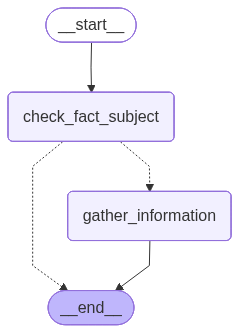

In [7]:
"""
Graph Definition for Checkable Nodes

"""

graph = StateGraph(AgentState, input_schema=AgentInputState)

graph.add_node("check_fact_subject", check_fact_subject)
graph.add_node("gather_information", gather_information)

# Entry point
graph.add_edge(START, "check_fact_subject")
graph.add_edge("gather_information", END)

fact_bot = graph.compile()

#visualization
try:
    from IPython.display import Image, display
    display(Image(fact_bot.get_graph().draw_mermaid_png()))
except Exception:
    pass


Run the agent in iterations, prompting the user everytime and log the conversation

In [8]:
"""S
Main loop to run the agent interactively.
"""

def running_agent():
    conversation_history: List[BaseMessage] = []

    try:
        # Get initial claim and KEEP it in history before first invoke
        user_input = input("\nWhat claim do you want to investigate? ")
        conversation_history.append(HumanMessage(content=user_input))

        # Initial state
        state: AgentState = {
            "messages": conversation_history,
            "claim": user_input,
            "checkable": None,
            "subject": None,
            "quantitative": None,
            "precision": None,
            "based_on": None,
            "await_user": False,
            "confirmed": False,
            "question": None,
        }

        print(f"CLAIM: {state.get('claim')}")

        while True:

            # Run the graph
            result = fact_bot.invoke(state)

            # Update rolling conversation
            conversation_history = list(result["messages"])

            # Determine what to ask next (confirmation or clarification)
            question_text = result.get("question")

            # Ask the question from the model/graph
            ai_question = AIMessage(content=question_text)
            conversation_history.append(ai_question)
            print("\n" + ai_question.content)

            # Get user's reply
            user_answer = input("> ")
            if user_answer.strip().lower() in ["exit", "quit"]:
                break
            else:
                conversation_history.append(HumanMessage(content=user_answer))

            # Keep claim FRESH so the next pass uses the *latest* user details
            state["messages"] = conversation_history
            state["claim"] = state.get("claim") + " " + user_answer

            # # If we just asked for confirmation, drop the flag so next turn proceeds
            # if result.get("confirmed"):
            #     state["confirmed"] = False

            # Clear question to avoid reuse of the same question
            state["question"] = None

        # Persist a readable log
        with open("logging.txt", "w", encoding="utf-8") as f:
            f.write("Your Conversation Log:\n")
            for m in conversation_history:
                if isinstance(m, HumanMessage):
                    f.write(f"You: {m.content}\n")
                elif isinstance(m, AIMessage):
                    f.write(f"AI: {m.content}\n\n")
            f.write("End of Conversation\n")

        print("Conversation saved to logging.txt")

    except KeyboardInterrupt:
        print("\nInterrupted by user. Goodbye!")

# run it
running_agent()


CLAIM: The addendum to the EU-Morocco Agreement does not comply with the decision made by the EU Court of Justice
None

=== 1. CHECKABLE? ===
POTENTIALLY CHECKABLE
The claim is about a specific legal compliance issue involving the EU Court of Justice, which is a factual statement that can be verified but requires clarification.
subject: addendum to the EU-Morocco Agreement
question: Does the addendum to the EU-Morocco Agreement comply with the decision made by the EU Court of Justice?
alerts: []
None


Task gather_information with path ('__pregel_pull', 'gather_information') wrote to unknown channel branch:to:__end__, ignoring it.



=== 2. Evidence retrieved? ===
quantitative: False
precision: vague
based on: unclear
The claim is about legal compliance without specific numerical data or measurable quantities.
question: What specific legal provisions or decisions of the EU Court of Justice are being referred to in this claim?
alerts: []

What specific legal provisions or decisions of the EU Court of Justice are being referred to in this claim?
None


Task check_fact_subject with path ('__pregel_pull', 'check_fact_subject') wrote to unknown channel branch:to:__end__, ignoring it.



=== 1. CHECKABLE? ===
POTENTIALLY CHECKABLE
The claim is about legal compliance without specific numerical data or measurable quantities, making it ambiguous and requiring clarification.
subject: 
question: Which specific legal provisions or decisions of the EU Court of Justice are being referred to in this claim?
alerts: []

Which specific legal provisions or decisions of the EU Court of Justice are being referred to in this claim?
Conversation saved to logging.txt
